In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using Blink
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc-2/packages/lib/v0.6/LCPSim.ji for module LCPSim.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc-2/packages/lib/v0.6/LearningMPC.ji for module LearningMPC.


In [3]:
robot = BoxAtlas()
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 8033`, ProcessRunning), TCPSocket(RawFD(51) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#3))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(56) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#3)), Future(1, 1, 1, Nullable{Any}(true))))

In [4]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 128, 128, 1])
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [5]:
sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.call_each(
    sample_sink,
    playback_sink,
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.call_each(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller,
        0.2),
    live_viewer
    )

dataset = LearningMPC.Dataset(lqrsol)

x_init = nominal_state(robot)

function collect_into!(data::Vector{<:LearningMPC.Sample}, σv)
    empty!(sample_sink)
    LearningMPC.randomize!(x0, x_init, 0.0, σv)
    results = LCPSim.simulate(x0, 
        dagger_controller,
        robot.environment, params.Δt, 100, 
        params.lcp_solver;
        termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
    append!(data, sample_sink.samples)
end

x0 = MechanismState{Float64}(robot.mechanism)

features(s::LearningMPC.Sample) = (s.state, s.mip.objective_bound, s.mip.objective_value)

features (generic function with 1 method)

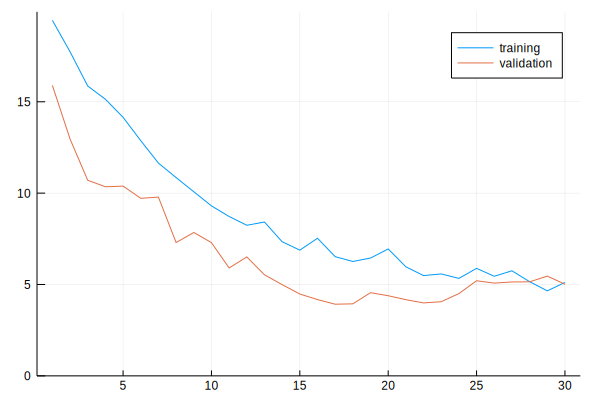

  7.428172 seconds (2.03 M allocations: 164.510 MiB, 1.15% gc time)


Progress:   1%|                                         |  ETA: 1 days, 6:06:14

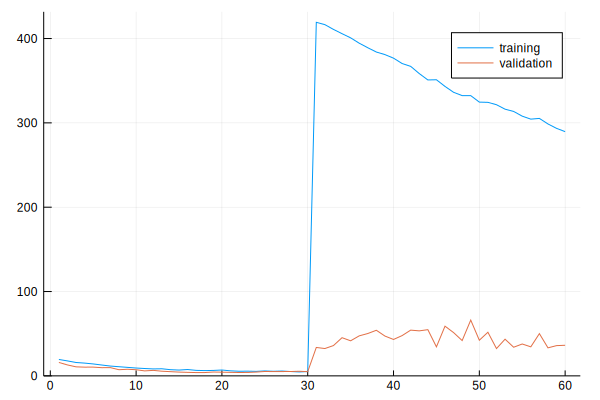

  5.339495 seconds (1.06 M allocations: 147.123 MiB, 1.10% gc time)


Progress:   2%|█                                        |  ETA: 20:32:50

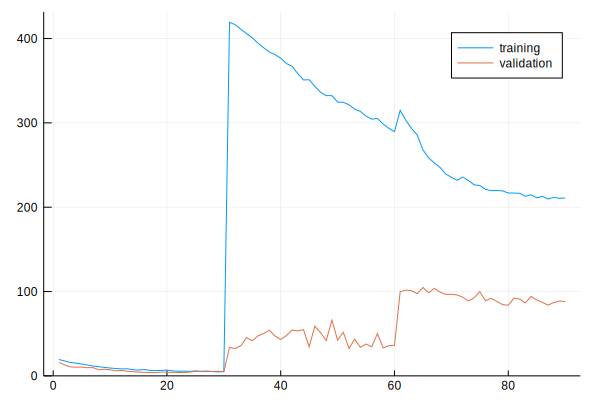

  6.192675 seconds (1.24 M allocations: 170.911 MiB, 1.39% gc time)


Progress:   3%|█                                        |  ETA: 15:16:13

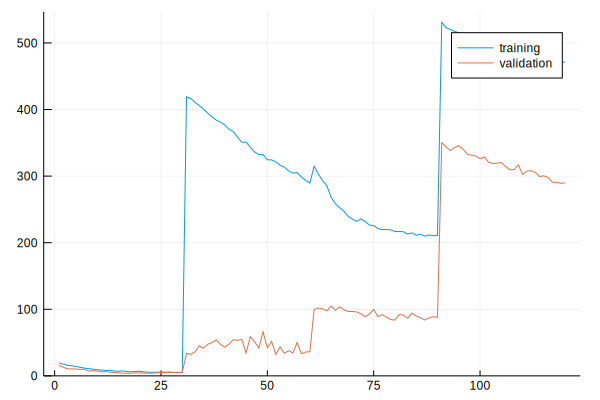

  6.765519 seconds (1.48 M allocations: 205.053 MiB, 1.21% gc time)


Progress:   4%|██                                       |  ETA: 14:05:40

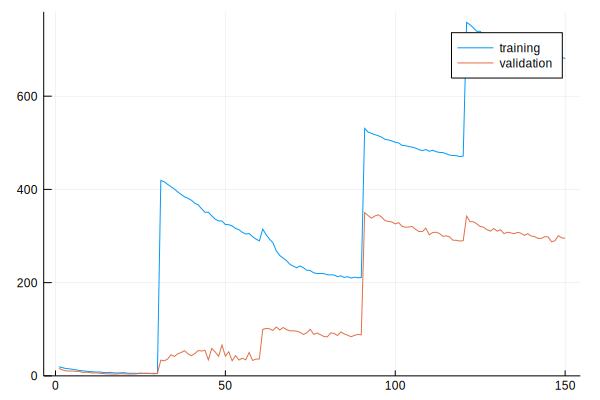

 10.878725 seconds (1.67 M allocations: 232.677 MiB, 1.06% gc time)


Progress:   5%|██                                       |  ETA: 12:46:14

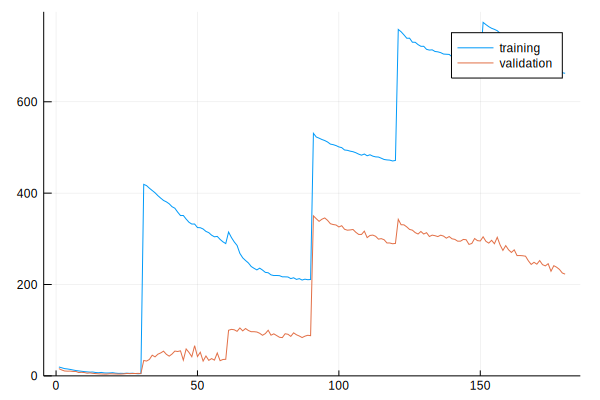

 14.033962 seconds (1.79 M allocations: 248.719 MiB, 1.37% gc time)


Progress:   6%|██                                       |  ETA: 11:20:50

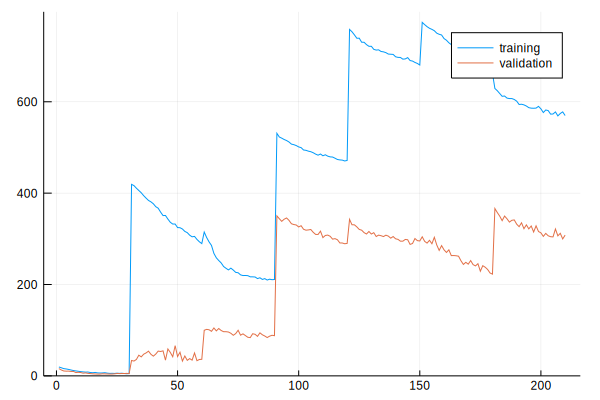

  8.891681 seconds (1.96 M allocations: 272.786 MiB, 1.09% gc time)


Progress:   7%|███                                      |  ETA: 10:29:14

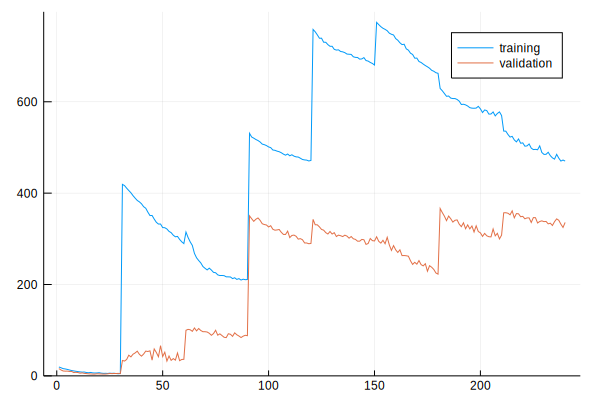

 22.961428 seconds (2.22 M allocations: 309.621 MiB, 2.55% gc time)


Progress:   8%|███                                      |  ETA: 10:28:33

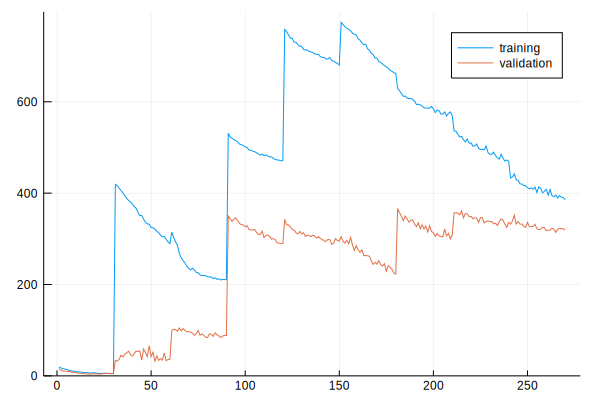

 42.647936 seconds (2.45 M allocations: 340.828 MiB, 0.46% gc time)


Progress:   9%|████                                     |  ETA: 10:38:45

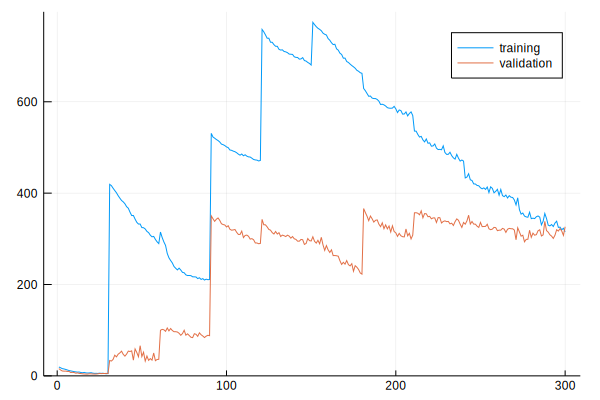

 42.360775 seconds (2.68 M allocations: 372.324 MiB, 0.69% gc time)


Progress:  10%|████                                     |  ETA: 10:41:52

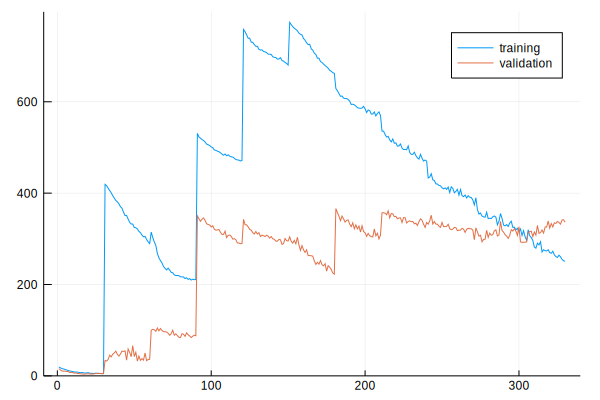

 22.331521 seconds (2.91 M allocations: 405.022 MiB, 1.06% gc time)


Progress:  11%|█████                                    |  ETA: 10:39:11

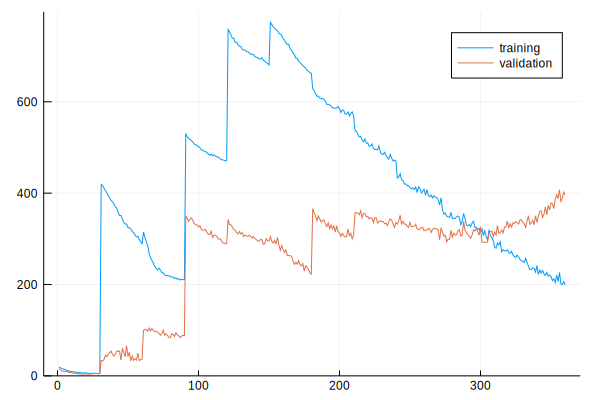

 90.116474 seconds (3.19 M allocations: 443.660 MiB, 0.45% gc time)


Progress:  12%|█████                                    |  ETA: 10:43:48

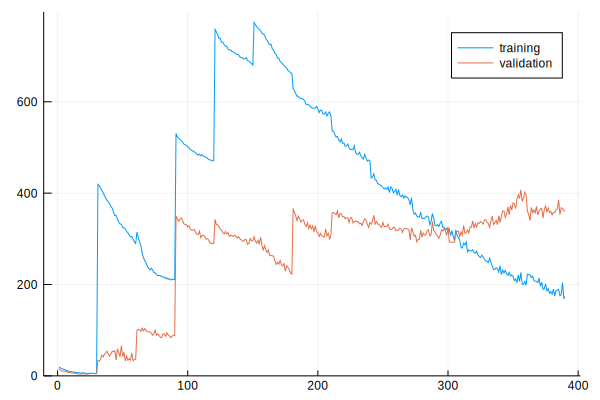

 15.091082 seconds (3.55 M allocations: 493.015 MiB, 1.39% gc time)


Progress:  13%|█████                                    |  ETA: 11:19:07

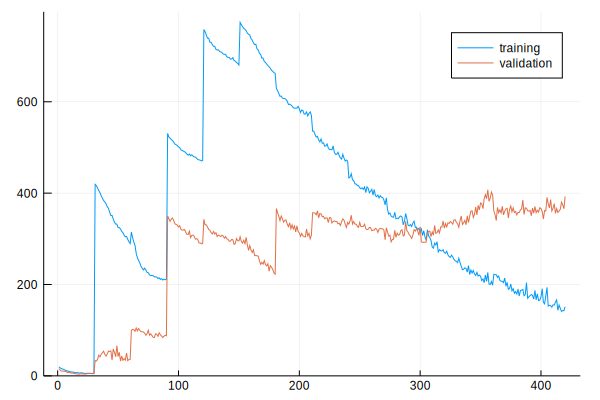

 18.598908 seconds (3.59 M allocations: 498.066 MiB, 1.14% gc time)


Progress:  14%|██████                                   |  ETA: 10:32:04

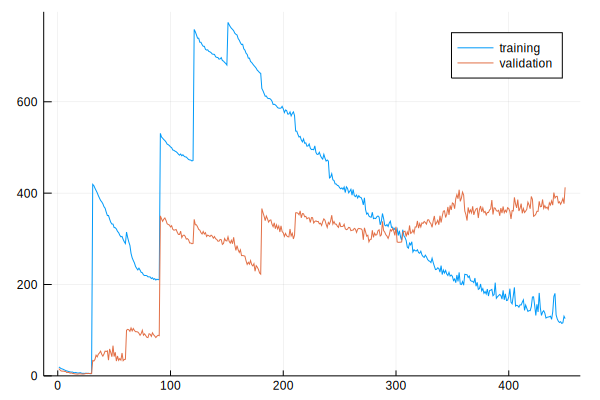

 14.623746 seconds (3.77 M allocations: 523.298 MiB, 1.59% gc time)


Progress:  15%|██████                                   |  ETA: 10:12:24

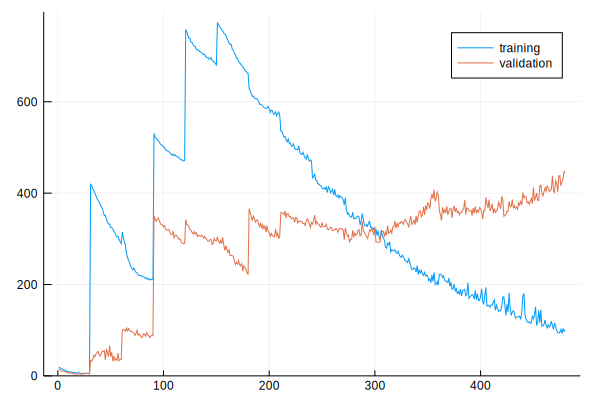

 16.050111 seconds (3.81 M allocations: 529.238 MiB, 1.37% gc time)


Progress:  16%|███████                                  |  ETA: 9:33:06

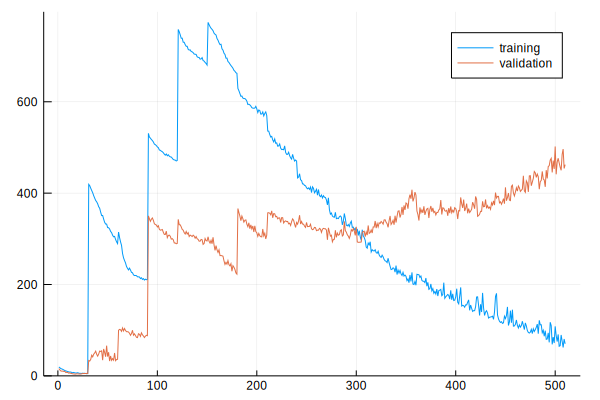

 15.049201 seconds (4.00 M allocations: 555.999 MiB, 1.41% gc time)


Progress:  17%|███████                                  |  ETA: 9:30:59

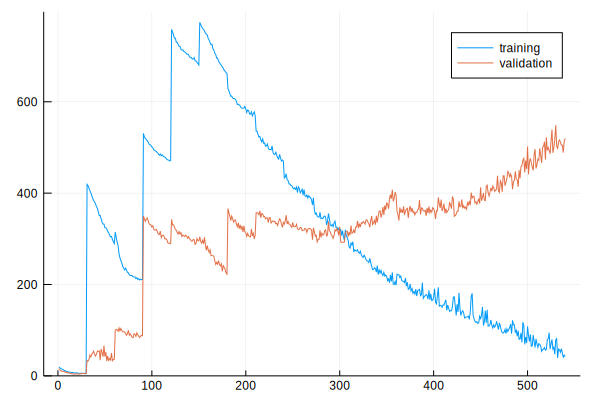

 22.002165 seconds (4.07 M allocations: 564.341 MiB, 1.29% gc time)


Progress:  18%|███████                                  |  ETA: 9:01:24

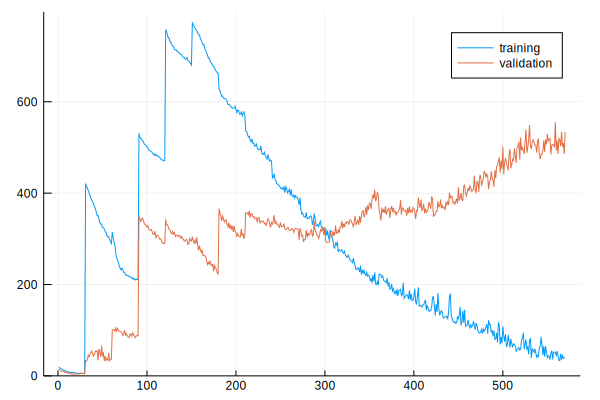

 17.725572 seconds (4.23 M allocations: 586.612 MiB, 1.39% gc time)


Progress:  19%|████████                                 |  ETA: 8:44:07

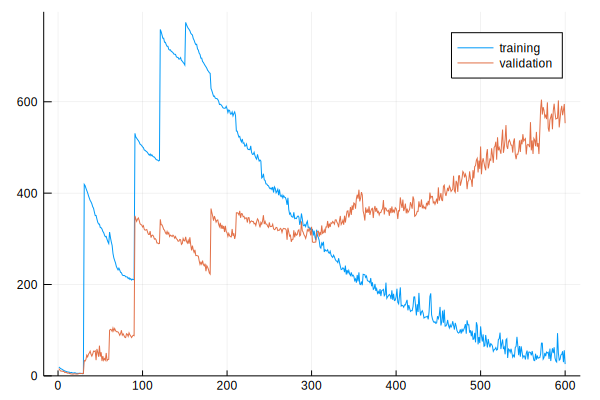

 19.016813 seconds (4.32 M allocations: 599.685 MiB, 1.32% gc time)


Progress:  20%|████████                                 |  ETA: 8:26:54

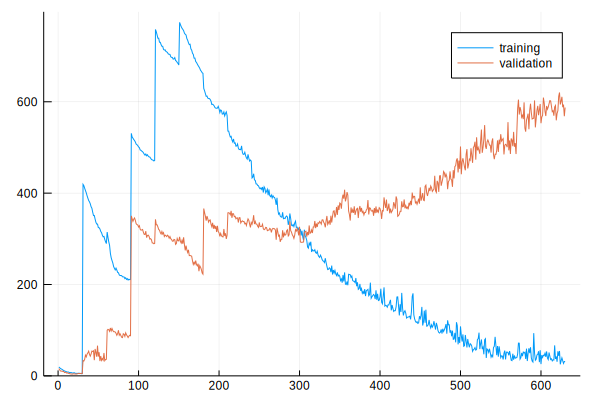

 18.712530 seconds (4.35 M allocations: 603.848 MiB, 1.46% gc time)


Progress:  21%|█████████                                |  ETA: 8:04:28

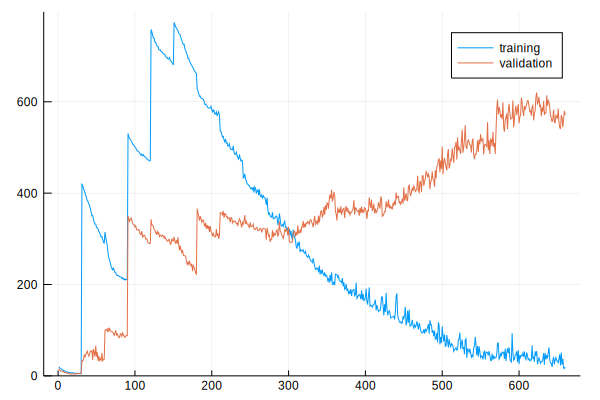

 23.248331 seconds (4.51 M allocations: 625.249 MiB, 1.07% gc time)


Progress:  22%|█████████                                |  ETA: 7:49:38

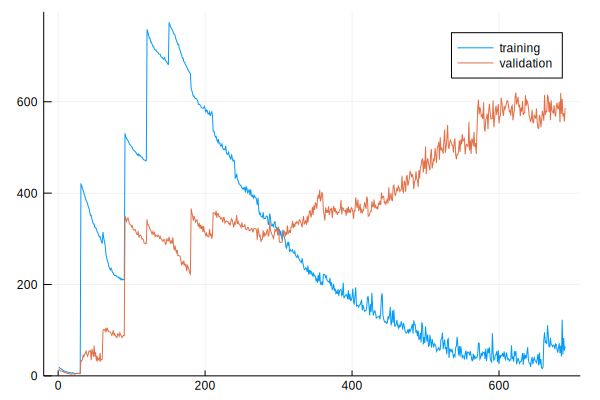

 17.611321 seconds (4.68 M allocations: 649.621 MiB, 1.82% gc time)


Progress:  23%|█████████                                |  ETA: 7:33:53

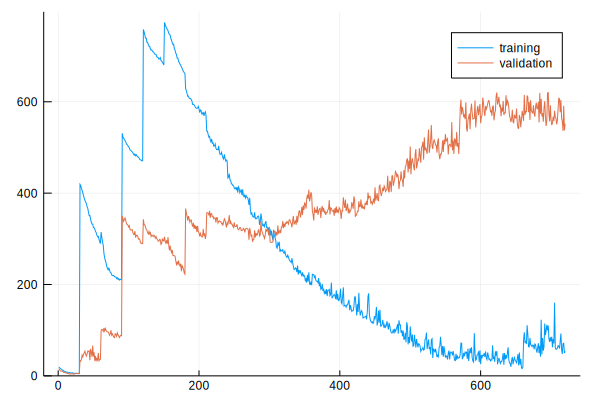

 31.245790 seconds (4.84 M allocations: 671.326 MiB, 1.02% gc time)


Progress:  24%|██████████                               |  ETA: 7:18:45

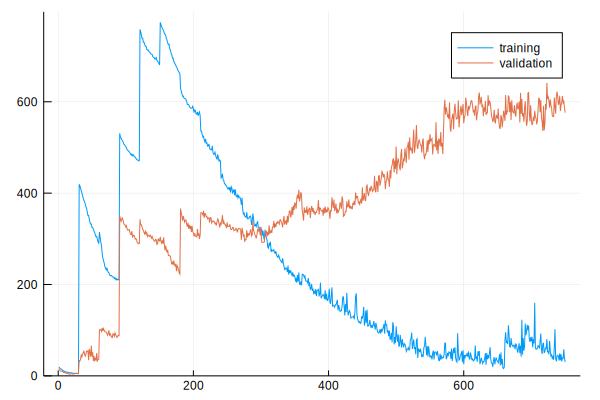

 17.282111 seconds (4.94 M allocations: 685.567 MiB, 1.61% gc time)


Progress:  25%|██████████                               |  ETA: 7:07:05

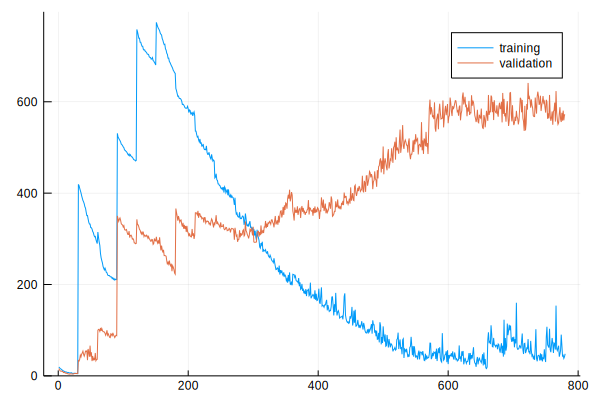

 18.283272 seconds (5.17 M allocations: 716.792 MiB, 1.59% gc time)


Progress:  26%|███████████                              |  ETA: 6:59:10

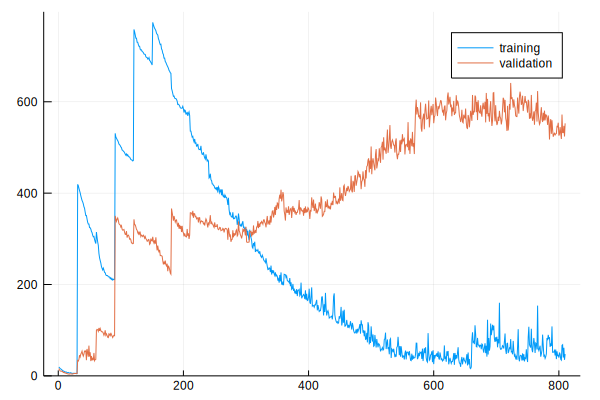

 24.675319 seconds (5.42 M allocations: 751.572 MiB, 1.29% gc time)


Progress:  27%|███████████                              |  ETA: 6:58:43

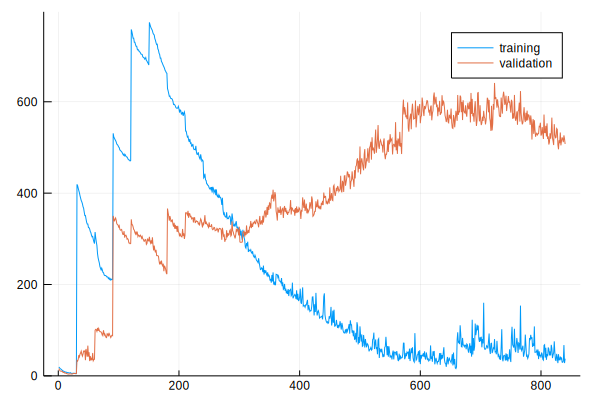

 20.494229 seconds (5.62 M allocations: 778.328 MiB, 1.62% gc time)


Progress:  28%|███████████                              |  ETA: 6:54:55

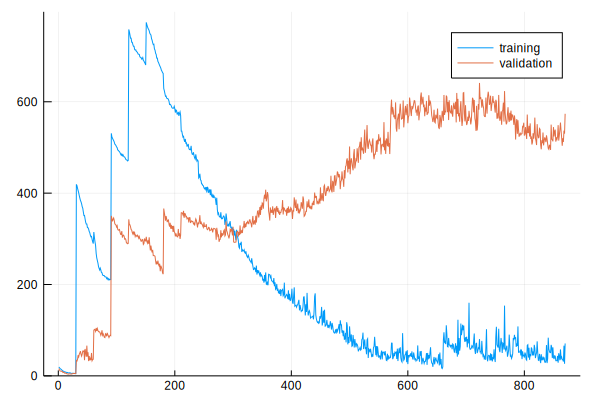

 34.045719 seconds (5.79 M allocations: 802.116 MiB, 0.93% gc time)


Progress:  29%|████████████                             |  ETA: 6:45:12

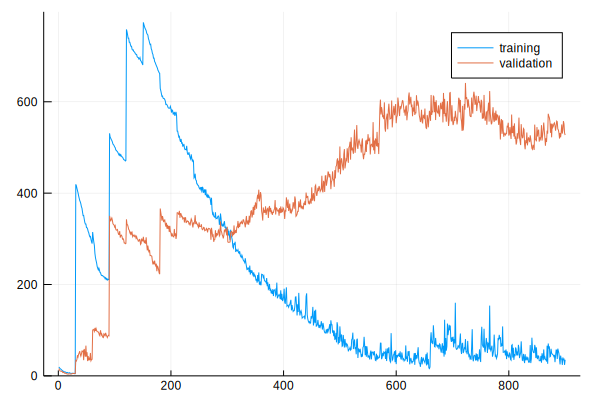

 32.225136 seconds (5.88 M allocations: 813.996 MiB, 1.19% gc time)


Progress:  30%|████████████                             |  ETA: 6:32:36

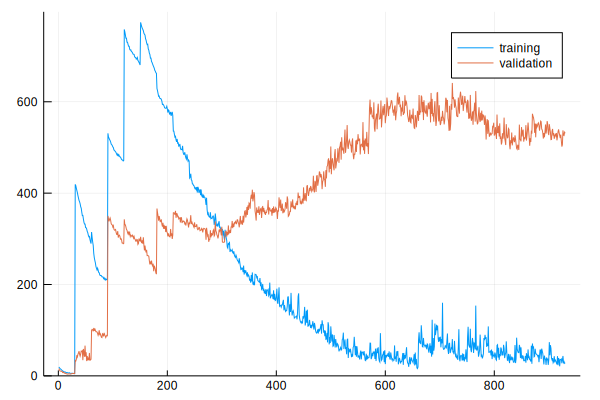

 29.121114 seconds (5.97 M allocations: 827.071 MiB, 1.41% gc time)


Progress:  31%|█████████████                            |  ETA: 6:20:46

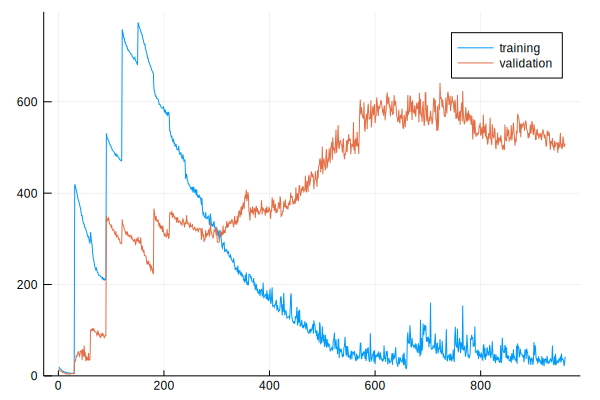

 29.695711 seconds (6.05 M allocations: 838.369 MiB, 1.27% gc time)


Progress:  32%|█████████████                            |  ETA: 6:09:33

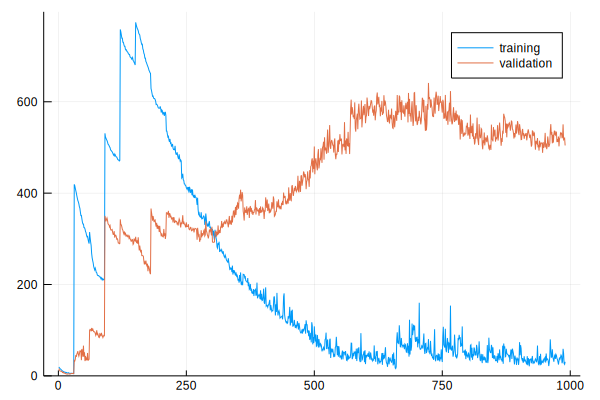

 26.372768 seconds (6.32 M allocations: 875.787 MiB, 1.35% gc time)


Progress:  33%|██████████████                           |  ETA: 6:06:37

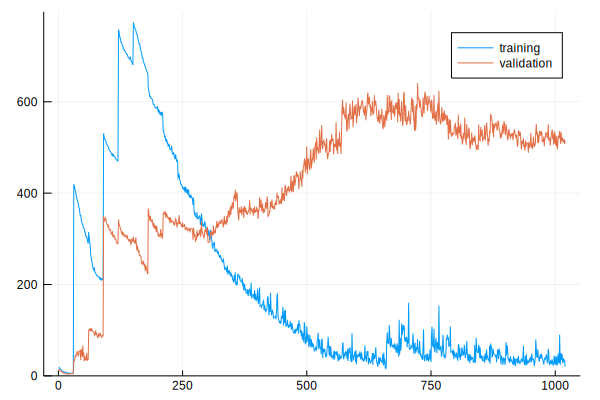

 34.485631 seconds (6.45 M allocations: 894.218 MiB, 1.15% gc time)


Progress:  34%|██████████████                           |  ETA: 5:56:38

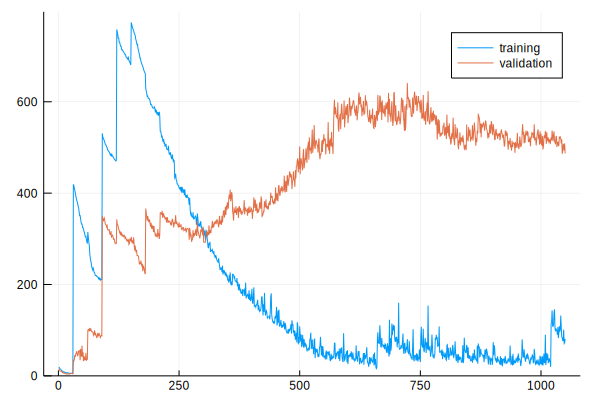

 33.811742 seconds (6.61 M allocations: 915.954 MiB, 1.25% gc time)


Progress:  35%|██████████████                           |  ETA: 5:46:56

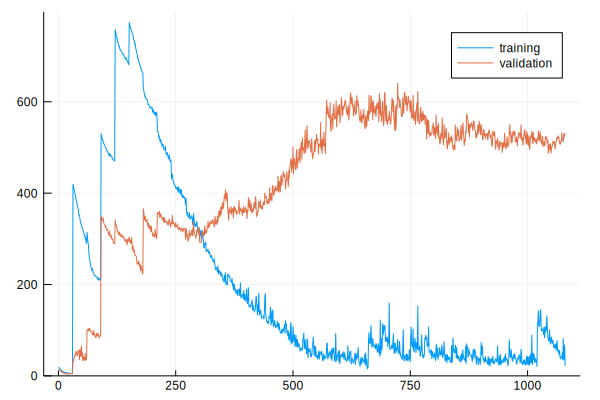

 34.846002 seconds (6.67 M allocations: 923.641 MiB, 1.17% gc time)


Progress:  36%|███████████████                          |  ETA: 5:37:06

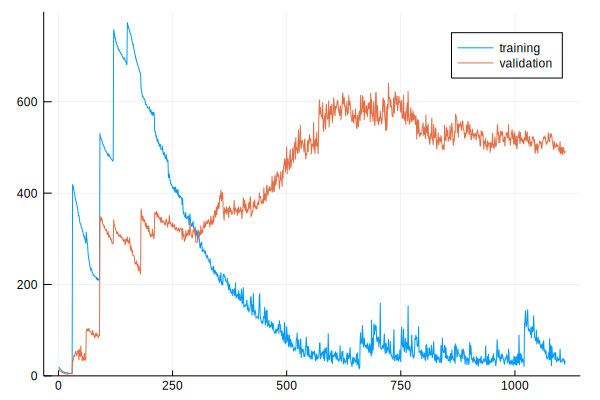

 35.260719 seconds (6.91 M allocations: 958.114 MiB, 1.26% gc time)


Progress:  37%|███████████████                          |  ETA: 5:34:11

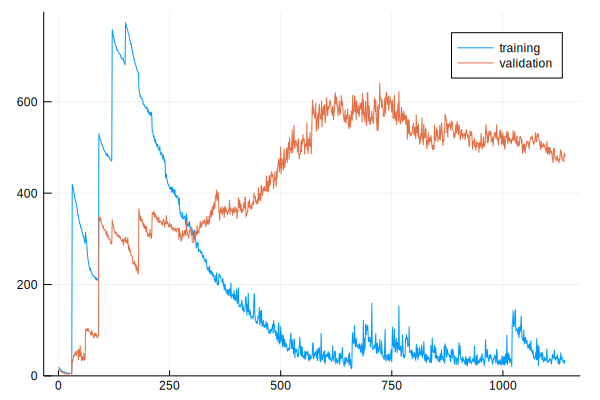

 41.720376 seconds (7.16 M allocations: 991.701 MiB, 1.16% gc time)


Progress:  38%|████████████████                         |  ETA: 5:28:58

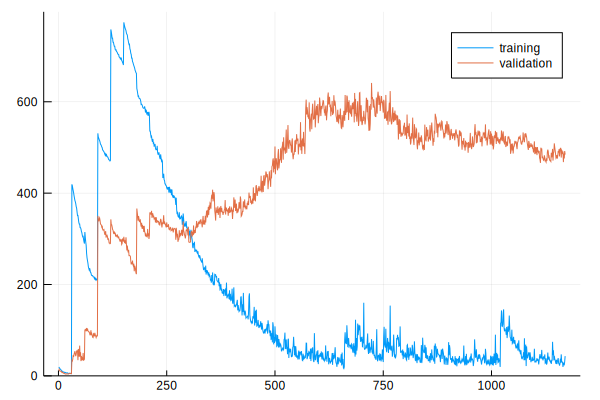

 48.703882 seconds (7.35 M allocations: 1019.017 MiB, 0.87% gc time)


Progress:  39%|████████████████                         |  ETA: 5:26:40

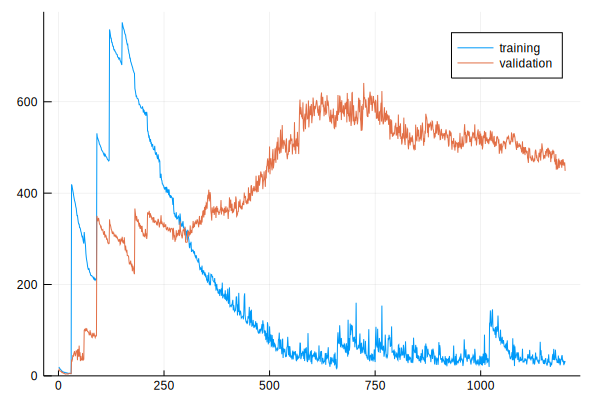

 42.468495 seconds (7.60 M allocations: 1.029 GiB, 1.42% gc time)


Progress:  40%|████████████████                         |  ETA: 5:22:38

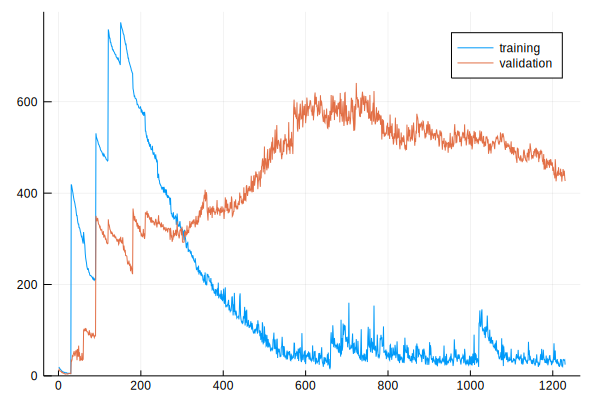

 44.500854 seconds (7.79 M allocations: 1.055 GiB, 0.96% gc time)


Progress:  41%|█████████████████                        |  ETA: 5:18:05

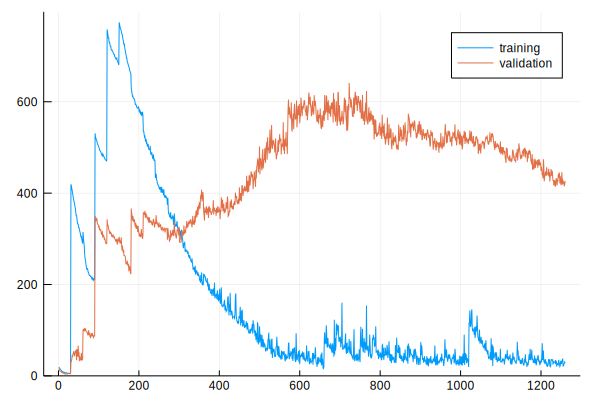

 69.861155 seconds (7.93 M allocations: 1.073 GiB, 0.95% gc time)


Progress:  42%|█████████████████                        |  ETA: 5:10:38

In [ ]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
all_training_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
all_validation_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 3.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, i / N_iter * σv)
    end
    collect_into!(dataset.testing_data, i / N_iter * σv)
    collect_into!(dataset.validation_data, i / N_iter * σv)
    append!(all_training_data, features.(dataset.training_data))
    append!(all_validation_data, features.(dataset.validation_data))
    filter!(all_training_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    filter!(all_validation_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    
    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen("boxatlas.jld2", "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt,
            "horizon" => params.horizon,
        )
        file["all_training_data"] = all_training_data
        file["all_validation_data"] = all_validation_data
        file["losses"] = losses
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end

In [16]:
x0 = nominal_state(robot)
set_velocity!(x0, findjoint(robot.mechanism, "floating_base"), [-0.5, 0, 0])
results = LCPSim.simulate(x0, net_mpc_controller, environment(robot), 0.01, 300, params.lcp_solver);

setanimation!(mvis, results)



true